In [1]:
"""
Install virtual enviroment outside project folder.
In command line enter:
python3 -m venv multimodal
pip install ipykernel
python3 -m ipykernel install --user --name=multimodal
Start `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks
Select `multimodal` kernel in right upper corner.
"""
# !pip install -r ../requirements.txt

'\nInstall virtual enviroment outside project folder.\nIn command line enter:\npython3 -m venv multimodal\npip install ipykernel\npython3 -m ipykernel install --user --name=multimodal\nStart `Jupyter Lab` at /Multimodal-Deep-Regression/notebooks\nSelect `multimodal` kernel in right upper corner.\n'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import time
import whisper
import numpy
import warnings

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, process_data, add_ae_tensor, get_ensemble_data, generate_batch_ensemble, generate_autoencoder_batch
from util.audio_utilities import extract_embeddings, extract_audio

In [2]:
# Preprocessing paramemter & ConvLSTMAutoencoder
DEVICE = 'cpu' # get_device() # CPU or GPU 
DATASET = 'video_pack_1000'
FRAME_SKIP = 200 # how many frame to skip, reduce depth
SHRINK = 8 # shrink the scale (H x W)//N
NORMALIZE = False # normalize the pixel to 0 to 1
PAD_ALL = False # pad all tensors with max depth
BATCH_SIZE = 10

EXTRACT_DATA = False # Set whether to run cells that extract data

In [3]:
# ConvLSTMAutoencoder Hyper-Parameters
LEARNING_RATE = 1e-4
EPOCHS = 10
HIDDEN_SIZE = 64 # ConvLSTMAutoencoder hidden size

In [4]:
# Transformer Visual & Audio Hyper-Parameters
NUM_HEADS = 8 # number of attenion heads
HIDDEN_DIM = 256 # Transformer hidden size
NUM_LAYERS = 6 # number of Transformer layers

# EnsembleModel Hyper-Parameters
LEARNING = 1e-3
THE_EPOCHS = 10
AUDIO_TRANSFORMER = False # if False, will skip audio transfomer part #NOT WORKING YET
LATE_FUSION = True # early fusion or late fusion #NOT WORKING YET

In [5]:
if EXTRACT_DATA:
    # extract audio from video dataset
    # extract_audio(f"../data/video_packs/{DATASET}/", f"../data/audio/{DATASET}")

    # using whipser to transcribe audio dialog & extract LLMs embedding
    extract_embeddings(audio_file_path=f"../data/audio/{DATASET}", output_dir="../data/audio_embeddings/", device=DEVICE)

In [6]:
if EXTRACT_DATA:
    # disable pyav warning
    warnings.filterwarnings("ignore", message="Accurate seek is not implemented for pyav backend")

    # video visual processing
    process_data(
        input_type=DATASET, 
        #addition_parameters={'first_n_videos': 10}, 
        verbose=False,
        device=get_device(),
        frames_to_skip=FRAME_SKIP,
        shrink=SHRINK,
        normalize=NORMALIZE
        )

In [7]:
x_dir, y_dir = get_base_tensor_directories(input_type=DATASET)

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)]) 
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

In [8]:
# load all visual tensors
x_data = [torch.load(f) for f in x_files] 
y_data = [torch.load(f) for f in y_files] 

# split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 2, 128, 72])
torch.Size([3, 15, 128, 72])
800
200


In [9]:
# Create AutoEncoder Batches with DataLoaders
batch_size = BATCH_SIZE
train_loader = list(zip(x_train, x_train))
val_loader = list(zip(x_val, x_val))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_autoencoder_batch)

# check size Batch, Channel, Frame, Height, Width
data, targets = next(iter(train_loader))
data.size(), targets.size()

(torch.Size([10, 3, 4, 128, 72]), torch.Size([10, 3, 4, 128, 72]))

In [10]:
from models import ConvLSTMAutoencoder

autoencoder = ConvLSTMAutoencoder(hidden_dim=HIDDEN_SIZE, shrink=SHRINK, normalize=NORMALIZE)
autoencoder = autoencoder.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)

total_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 1,041,859


In [11]:
ECHO = 1 # print in N epoch only when training
SAVE_NAME = 'ConvLSTMAutoencoder_hidden6222_weights.pt' # save the weights
autoencoder_load = True

In [12]:
# load check point
weights_file = f'../models/save/{SAVE_NAME}'
autoencoder.load_state_dict(torch.load(weights_file)['model_state_dict'])
autoencoder_load = True
train_losses = torch.load(weights_file)['train_losses']
val_losses = torch.load(weights_file)['val_losses']

In [13]:
if not autoencoder_load:
    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        train_loss, avg_train_loss = train(autoencoder, train_loader, criterion, optimizer, DEVICE)
        val_loss, avg_val_loss = evaluate(autoencoder, val_loader, criterion, DEVICE)
        
        # record the losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # print every num times epoch only
        echo = ECHO
        if ((epoch+1) % echo == 0) or epoch == 0:
            if epoch == 0:
                time_took = (time.time() - start_time) / 60
                print(f'First epoch took {time_took:.1f} minutes.')
            print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

In [14]:
if not autoencoder_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': autoencoder.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

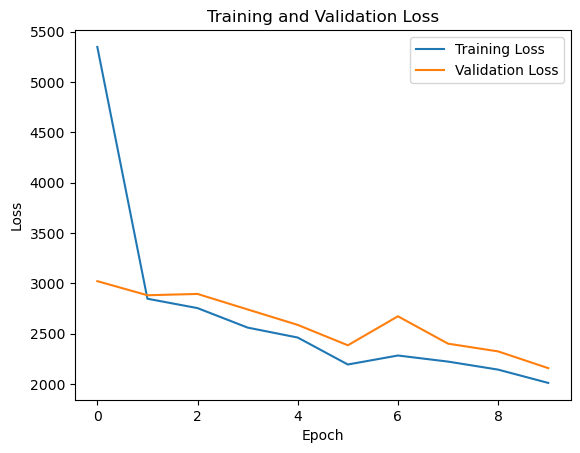

In [15]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Actual:
torch.Size([3, 128, 72])


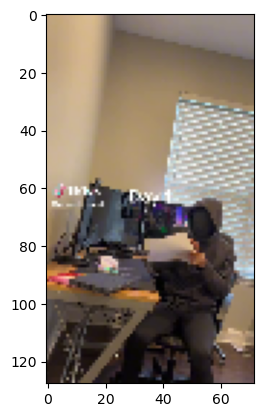

torch.Size([3, 128, 72])


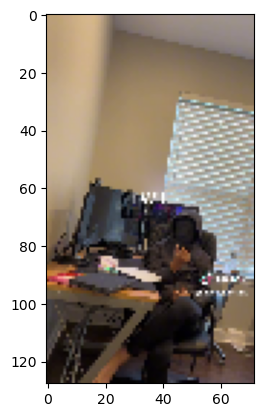

torch.Size([3, 128, 72])


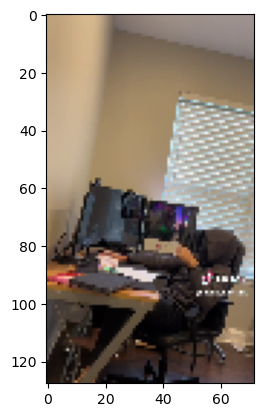

AutoEncoder:


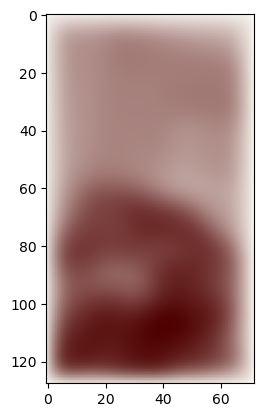

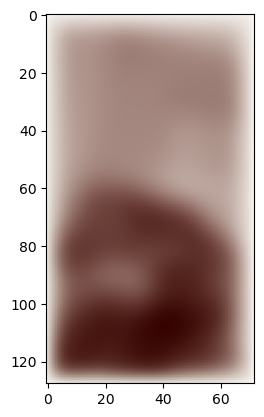

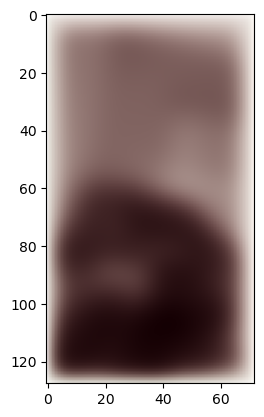

In [16]:
# Random sample inspection
random_num = random.randint(0, len(val_loader)-1)

for i, (inputs, targets) in enumerate(val_loader):
    if i == random_num:  # random sample
        inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)
        outputs = autoencoder(inputs).detach()
        break

        
# Actual
print('Actual:')
for i in range(3):
    # select first 3 frame
    image_tensor = targets.squeeze()[0,:,i,:,:]
    print(image_tensor.size())
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()
    
# AutoEncoder
print('AutoEncoder:')
for i in range(3):
    # select first 3 frame
    image_tensor = outputs.squeeze()[0,:,i,:,:]
    numpy_image = image_tensor.detach().numpy()

    # imshow (Height, Width, Channels)
    numpy_image = numpy_image.transpose((1, 2, 0))

    # normalize to 0,1
    numpy_image = (numpy_image - numpy_image.min()) / (numpy_image.max() - numpy_image.min())

    plt.imshow(numpy_image)
    plt.show()

In [15]:
# load ensemble data
x_data, y_data = get_ensemble_data(x_files, DATASET)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)

In [16]:
import pandas as pd
import numpy as np

In [17]:
y_train_raw = np.array([i.item() for i in y_train])
df_describe = pd.DataFrame(y_train_raw)
df_describe.describe()

,0
count,800.000000
mean,7260.918375
std,20648.766175
min,10.600000
25%,403.599998
50%,2100.000000
75%,7500.500000
max,373000.000000


array([[<Axes: title={'center': '0'}>]], dtype=object)

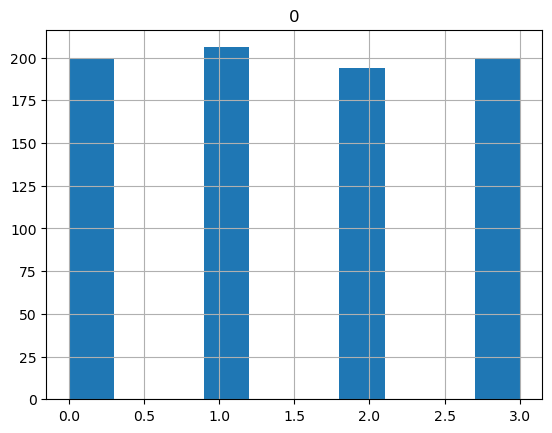

In [18]:
y_train_encoded = np.where(
    y_train_raw <= 403.599998,
    0,
    np.where(
        y_train_raw <= 2100.000000,
        1,
        np.where(
            y_train_raw <= 7500.500000,
            2,
            3
        )
    )
)
df_describe2 = pd.DataFrame(y_train_encoded)
df_describe2.hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

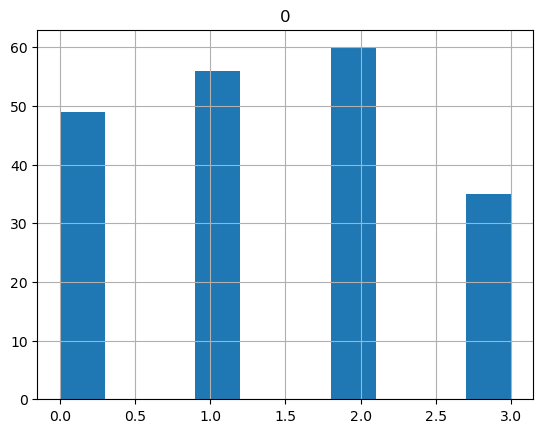

In [19]:
y_val_raw = np.array([i.item() for i in y_val])
y_val_encoded = np.where(
    y_val_raw <= 403.599998,
    0,
    np.where(
        y_val_raw <= 2100.000000,
        1,
        np.where(
            y_val_raw <= 7500.500000,
            2,
            3
        )
    )
)
df_describe2 = pd.DataFrame(y_val_encoded)
df_describe2.hist()

In [20]:
y_train_one_hot_encoded = np.zeros((y_train_encoded.size, y_train_encoded.max() + 1))
y_train_one_hot_encoded[np.arange(y_train_encoded.size), y_train_encoded] = 1
y_train_one_hot_encoded

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [21]:
y_val_one_hot_encoded = np.zeros((y_val_encoded.size, y_val_encoded.max() + 1))
y_val_one_hot_encoded[np.arange(y_val_encoded.size), y_val_encoded] = 1
y_val_one_hot_encoded

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],


In [22]:
y_train_one_hot_encoded = torch.tensor(y_train_one_hot_encoded)
y_val_one_hot_encoded = torch.tensor(y_val_one_hot_encoded)

In [23]:
y_val_one_hot_encoded.shape

torch.Size([200, 4])

In [24]:
train_loader = list(zip(x_train, y_train_one_hot_encoded))
val_loader = list(zip(x_val, y_val_one_hot_encoded))
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch_ensemble)

print(f'Train set size: {len(x_train)}')
print(f'Val set size: {len(x_val)}')

Train set size: 800
Val set size: 200


In [26]:
from models import TransformerModel_Visual, TransformerModel_Audio, EnsembleModelClassifier

model1 = TransformerModel_Visual(
    d_model = 9216,
    nhead = NUM_HEADS,
    d_hid = HIDDEN_DIM,
    nlayers = NUM_LAYERS
)

if AUDIO_TRANSFORMER:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS
    )
else:
    model2 = TransformerModel_Audio(
        d_model = 512,
        nhead = NUM_HEADS,
        d_hid = HIDDEN_DIM ,
        nlayers = NUM_LAYERS,
        pass_transformer=True
    )

ensemble_model = EnsembleModelClassifier(model1,model2)
total_params = sum(p.numel() for p in ensemble_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 2,219,420,164


In [27]:
# Training
def ensemble_train(ensemble_model, autoencoder, dataloader, criterion, optimizer, device='cpu', verbose=False):
    ensemble_model.train()
    total_loss = 0.0
    for visuals, audio_embeds, targets in dataloader:
        visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
        visual_embeds = autoencoder.getembedding(visuals).detach()
        outputs = ensemble_model.forward(visual_embeds, audio_embeds)
        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        return total_loss, avg_loss

# Evaluate
def ensemble_evaluate(ensemble_model, autoencoder, dataloader, criterion, device='cpu', verbose=False):
    ensemble_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for visuals, audio_embeds, targets in dataloader:
            visuals, audio_embeds, targets = visuals.to(device), audio_embeds.to(device), targets.to(device)
            visual_embeds = autoencoder.getembedding(visuals).detach()
            outputs = ensemble_model.forward(visual_embeds, audio_embeds)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            return total_loss, avg_loss

In [28]:
ECHO = 1  # print in N epoch only when training
SAVE_NAME = 'EnsembleModel_hidden51222_weights.pt'  # save the weights
ensemble_model_load = False

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(),lr=LEARNING)

EPOCHS = 20
start_time = time.time()

if not ensemble_model_load:
    train_losses = []
    val_losses = []

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = ensemble_train(ensemble_model, autoencoder, train_loader, criterion, optimizer, DEVICE, verbose=True)
    val_loss, avg_val_loss = ensemble_evaluate(ensemble_model, autoencoder, val_loader, criterion, DEVICE, verbose=True)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = ECHO
    if ((epoch+1) % ECHO == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
if not ensemble_model_load:
    # save model if better or not exists
    model_weights = {'model_state_dict': ensemble_model.state_dict(), 'val_loss': avg_train_loss, 'train_losses':train_losses, 'val_losses':val_losses}
    weights_file = f'../models/save/{SAVE_NAME}'
    if not os.path.isfile(weights_file):
        # save new
        torch.save(model_weights, weights_file)
        print('save new model')
    elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
        # replace
        torch.save(model_weights, weights_file)
        print('replace old model')
    else:
        print('old model perform better')

replace old model


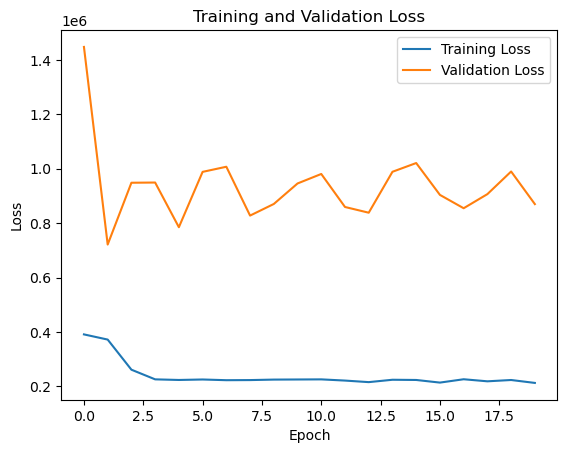

In [ ]:
# loss plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

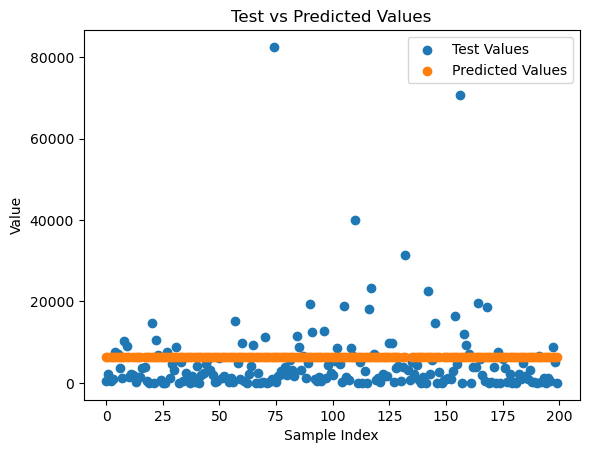

In [ ]:
# compare to validation set
val_values = []
predicted_values = []
    
for visuals, audio_embeds, targets in val_loader:
    visuals, audio_embeds, targets = visuals.to(DEVICE), audio_embeds.to(DEVICE), targets.to(DEVICE)
    visual_embeds = autoencoder.getembedding(visuals).detach()
    outputs = ensemble_model.forward(visual_embeds, audio_embeds).detach()
    # Append the values
    val_values.extend(targets.squeeze().tolist())
    predicted_values.extend(outputs.squeeze().tolist())
    
plt.scatter(range(len(val_values)), val_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Inspect first N
N = 100
val_check = [round(i, 2) for i in val_values][:N]
predicted_check = [round(i, 2) for i in predicted_values][:N]
print('Val', val_check)
print('Predict', predicted_check)

Val [462.4, 2100.0, 413.8, 855.7, 7500.0, 7100.0, 3700.0, 1100.0, 10300.0, 9000.0, 1400.0, 2200.0, 2000.0, 178.4, 1400.0, 1500.0, 3700.0, 4000.0, 589.1, 13.2, 14800.0, 18.3, 10600.0, 6800.0, 669.1, 99.1, 45.7, 7610.0, 1300.0, 4700.0, 3200.0, 8900.0, 14.6, 5200.0, 369.8, 2324.0, 626.9, 10.5, 1800.0, 118.0, 4200.0, 10.3, 2000.0, 2400.0, 4600.0, 6000.0, 3180.0, 1900.0, 153.6, 514.3, 6245.0, 1100.0, 1700.0, 1300.0, 319.8, 1100.0, 285.7, 15100.0, 4900.0, 1000.0, 9925.0, 387.5, 85.9, 2200.0, 4100.0, 9400.0, 10.6, 2500.0, 26.7, 179.2, 11400.0, 70.0, 133.3, 971.0, 82500.0, 177.4, 1600.0, 3000.0, 2300.0, 4000.0, 1900.0, 5700.0, 3200.0, 1800.0, 11500.0, 8800.0, 3200.0, 6542.0, 1200.0, 5000.0, 19400.0, 12500.0, 959.8, 360.8, 1500.0, 470.5, 12800.0, 1200.0, 4400.0, 2500.0]
Predict [6271.02, 6270.92, 6271.04, 6271.01, 6271.0, 6271.02, 6271.01, 6271.01, 6271.0, 6271.0, 6271.04, nan, 6271.0, 6271.0, 6270.99, 6271.0, nan, 6271.0, 6271.0, 6271.04, 6271.0, 6270.99, 6271.0, 6271.01, 6271.0, 6271.01, 6270

In [ ]:
# get MSE for the vaildation set
mse = mean_squared_error(val_values, predicted_values)
print(f'MSE: {mse:.2f}, Lenght: {len(val_values)}')

ValueError: Input contains NaN.